# 用朴素贝叶斯模型对金融新闻进行情感分析

## 第一步：读入数据

把数据`financial-news.csv`读入一个DataFrame中。

In [1]:
# read csv
import pandas as pd
import numpy as np
url = "financial-news.csv"
col_names = ["sentiment", "news"]
finews = pd.read_csv(url, names=col_names)

创建一个新的DataFrame，只包含Sentiment为negative和positive的数据。

In [2]:
# filter data
f_finews = finews[finews["sentiment"].isin(["negative", "positive"])]


## 第二步：生成X和y

使用新闻标题作为分类特征列，Sentiment为预测目标，将Sentiment转化成数值（negative为0，positive为1），并将数据集划分为训练集和测试集。

In [3]:
# define X and y
f_finews['sentiment'] = f_finews.sentiment.map({'negative': 0, 'positive': 1})
y = f_finews['sentiment']
X = f_finews['news']


C:\Users\wq\AppData\Local\Temp\ipykernel_8752\2720279744.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_finews['sentiment'] = f_finews.sentiment.map({'negative': 0, 'positive': 1})


In [4]:
# split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## 第三步：转换数据

使用CountVectorizer将X_train和X_test转换为document-term矩阵。

In [5]:
# import and instantiate the vectorizer
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [6]:
# fit and transform X_train, but only transform X_test
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

## 第四步：训练、预测、评价

使用朴素贝叶斯模型，预测测试集中新闻标题的情感类别，并计算预测精度。

In [7]:
# import/instantiate/fit
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

nb.fit(X_train_dtm, y_train)


MultinomialNB()

In [8]:
# make class predictions
y_pred_class = nb.predict(X_test_dtm)

In [9]:
# calculate accuracy
from sklearn import metrics

print(metrics.accuracy_score(y_test, y_pred_class))

0.8109756097560976


计算AUC。

In [10]:
# predict class probabilities
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]

In [11]:
# calculate the AUC using y_test and y_pred_prob
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.8753021442495128


绘制ROC曲线。

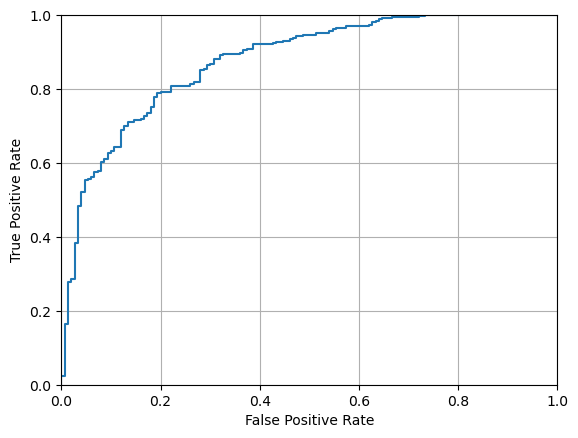

In [12]:
# plot ROC curve using y_test and y_pred_prob
import matplotlib.pyplot as plt

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)

显示混淆矩阵，并计算敏感度和特异性，评论结果。

In [13]:
# print the confusion matrix
confusion = metrics.confusion_matrix(y_test, y_pred_class)

print(confusion)

[[106  44]
 [ 49 293]]


In [14]:
# calculate sensitivity
print(metrics.recall_score(y_test, y_pred_class))

0.8567251461988304


In [15]:
# calculate specificity
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print(TN / float(TN + FP))


0.7066666666666667


对模型的敏感度和特异性做出评论：

## 第五步：错误分析

查看测试集中一些被预测错误的新闻标题，即false positives和false negatives。试着回答为什么这些新闻标题会被预测错。

In [16]:
# first 10 false positives (meaning they were incorrectly classified as positive sentiment)
df1 = X_test[y_test < y_pred_class]

print(df1[0:10])

1709    IT services firm TietoEnator was bucking the g...
4514    Rapala VMC Corporation STOCK EXCHANGE RELEASE ...
4284           This is bad news for the barbeque season .
4561    The Baltimore Police and Fire Pension , which ...
735     The payment of 2.779 million litas in interest...
4788    According to the company , in addition to norm...
4813    `` Capital expenditure on energy efficiency ha...
4799    In February the Elcoteq group sold its St Pete...
1710    Profitability ( EBIT % ) was 13.6 % , compared...
4077    The tightened competition situation in the pro...
Name: news, dtype: object


In [17]:
# first 10 false negatives (meaning they were incorrectly classified as negative sentiment)
df2 = X_test[y_test > y_pred_class]

df2.head(10)

2299    Raute posted a net profit of 1.8 mln euro $ 2....
740       Repeats sees 2008 EBITA above 18 pct of sales .
2300    Return on equity stood at 18.3 % compared to 1...
29      Operating profit for the three-month period in...
97      Net sales of Finnish food industry company L+苙...
718     Operating profit totalled EUR 7.0 mn , up from...
975     The borrower was happy to do the roadshow and ...
654     In contrast , the company 's net loss for the ...
2283    In the second quarter of 2010 , the company 's...
2170    Operating loss was EUR 179mn , compared to a l...
Name: news, dtype: object

## 第六步：多分类预测

使用所有的新闻标题做预测，而不仅仅是negative和positive的新闻标题。

In [18]:
# define X and y using the original DataFrame，remember to transform y into integers
url = "financial-news.csv"
col_names = ["sentiment", "news"]
finews = pd.read_csv(url, names=col_names)

finews["sentiment"] = finews.sentiment.map({"negative": 0, "neutral": 1, "positive": 2})

X_new = finews.news

y_new = finews.sentiment


In [19]:
# split into training and testing sets
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, y_new, random_state=0)


In [20]:
# create document-term matrices
X_new_train_dtm = vect.fit_transform(X_new_train)

X_new_test_dtm = vect.transform(X_new_test)


In [21]:
# fit a Naive Bayes model

nb.fit(X_new_train_dtm, y_new_train)


MultinomialNB()

In [22]:
# make class predictions

y_new_pred_class = nb.predict(X_new_test_dtm)


In [23]:
# calculate the testing accuary

print(metrics.accuracy_score(y_new_test, y_new_pred_class))


0.721947194719472


In [24]:
# print the confusion matrix

confusion_new = metrics.confusion_matrix(y_new_test, y_new_pred_class)

print(confusion_new)


[[ 61  57  38]
 [ 17 642  60]
 [ 16 149 172]]


有何评论：类别增加， Naive Bayes的精度会下降